## 10.3 注意力评分函数

下图以实现注意力框架。

![](../images/10-3-1.svg)

下面使用注意力汇聚函数$f$表示成值的加权和。

$$
\bm{f(q,(k_1,v_1),\dots,(k_m,v_m))=\sum_{i=1}^n\alpha(q,k_i)v_i}\in\mathbb{R}^v
$$

本节会介绍两个流行的评分函数。

In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

### 10.3.1 遮蔽softmax操作

也就是指定一个有效的序列长度，以便在计算softmax时候过滤掉超出指定范围的位置。

In [2]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

下面演示了有效长度分别为2和3的情况。

In [3]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.5143, 0.4857, 0.0000, 0.0000],
         [0.5271, 0.4729, 0.0000, 0.0000]],

        [[0.2458, 0.2564, 0.4977, 0.0000],
         [0.3450, 0.3808, 0.2742, 0.0000]]])

同样也可以使用二位向量为每一行指定长度。

In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2928, 0.3264, 0.3808, 0.0000]],

        [[0.4196, 0.5804, 0.0000, 0.0000],
         [0.2936, 0.2156, 0.1383, 0.3526]]])

### 10.3.2 加性注意力

当查询和键的是不同长度的矢量时候，可以使用加性注意力作为评分函数：

$$
\alpha(\bm{q},\bm{k})=\bm{w}^T\tanh(\bm{W}_q\bm{q}+\bm{W}_k\bm{k})\in\mathbb{R}
$$

这里的$\bm{W}_q\in\mathbb{R}^{h\times q}$、$\bm{W}_k\in\mathbb{R}^{h\times k}$和$\bm{w}_v\in\mathbb{R}^h$都是可学习的参数，其隐藏单元包含一个隐藏层，其单元数是一个超参数$h$。

In [5]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        """
        key_size:   int 键特征的维度
        query_size: int 查询特征的维度
        """
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，也就是下面的unsqueeze后
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

这里涉及到了广播规则，譬如一个`torch.Size([2, 2, 1, 8])`和`torch.Size([2, 1, 10, 8])`的张量执行相加，则会将它们`repeat`后拓展到`torch.Size([2, 2, 10, 8])`，也就是取每个张量每个维度的最大值。

**但是需要注意的是**，在上面这个例子中，改变的是第1和第2通道的维度（通道从0开始计数）。可以看到，这两个张量总有一个的第1或者第2通道数目为**1**。如果不是1，则无法进行广播了。

通过`w_v`后，上述例子中的`torch.Size([2, 2, 10, 8])`变成了`torch.Size([2, 2, 10, 1])`这时候把最后一个维度挤掉就好了，这时候的分数就代表2个查询在10个键值对上的注意力权重！

**遮掩操作的理解**：为什么要使用`masked_softmax`一般是因为精确控制每个批次样本的查询与哪些键值对发生关系，譬如下面的例子中，`valid_lens = torch.tensor([2, 6])`说明对于一个批次大小为2的样本而言，第1批样本仅与前面2个键值发生关系，第2批样本仅与前面6个键值发生关系，这样做的目的很迷。

In [6]:
queries, keys = torch.normal(0, 1, (2, 3, 20)), torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000],
         [ 2.0000,  3.0000,  4.0000,  5.0000],
         [ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000],
         [10.0000, 11.0000, 12.0000, 13.0000],
         [10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

下面来解释这里的维度含义

- `queries->(2, 3, 20)`：2个样本(batch_size)，每个样本有3个查询，每个查询的维度有20
- `keys->(2, 10, 2)`：2个样本(batch_size)，每个样本有10个键，每个键的维度为2
- `values->(2, 10, 4)`：2个样本(batch_size)，每个样本有10个值，每个值的维度为4

很显然，`keys`的第二个维度必须和`values`的第二个维度相同，否则无法构成键值对。

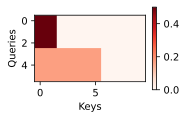

In [7]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 6, 10)),
                  xlabel='Keys', ylabel='Queries')

上面这个注意力矩阵显示，总共2批次共6条查询，前面一个批次的3条查询仅仅与前面的2个键值对发生了关系，后面一个批次的3条查询仅与前面的6个键值对发生了关系。

### 10.3.3 缩放点积注意力

点积操作更快更好，但是要求查询和键具有相同的长度d，其评分函数为

$$
\alpha(\bm{q},\bm{k})=\frac{\bm{q}^T\bm{k}}{\sqrt{d}}
$$

在实践中通常基于小批量来提高效率。
在这里每个批次共有$n$个查询，$m$个键值对，其中查询和键的特征长度为$d$，值的特征长度为$v$，那么查询$\bm{Q}\in\mathbb{R}^{n\times d}$、$\bm{K}\in\mathbb{R}^{m\times d}$以及$\bm{Q}\in\mathbb{R}^{m\times d}$的缩放点积注意力模型为：

$$
\mathrm{softmax}\left(\frac{\bm{Q}\bm{K}^T}{\sqrt{d}}\right)\bm{V}\in\mathbb{R}^{n\times v}
$$

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。

In [8]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens=None):
        """
        queries的形状：(batch_size，查询的个数，d)
        keys的形状：(batch_size，“键－值”对的个数，d)
        values的形状：(batch_size，“键－值”对的个数，值的维度)
        valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
        """
        assert queries.shape[-1] == keys.shape[-1]
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度，实现转置的效果
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

一样的例子，但是要令查询的特征维度和键的特征维度大小相同。

In [9]:
queries = torch.normal(0, 1, (2, 3, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000],
         [ 2.0000,  3.0000,  4.0000,  5.0000],
         [ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000],
         [10.0000, 11.0000, 12.0000, 13.0000],
         [10.0000, 11.0000, 12.0000, 13.0000]]])

由于键的元素是相同的，无法通过查询进行区分，因此获得了在对应掩膜外的均匀的注意力权重。

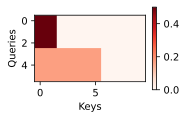

In [10]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 6, 10)),
                  xlabel='Keys', ylabel='Queries')

### 10.3.4 小结

- 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
- 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。